In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
from IPython.display import display, clear_output

# Constants

In [2]:
initial_board = np.zeros((6, 7), int)

# Game

In [3]:
class State():
    def __init__(self, board: np.array, player: int = np.random.randint(1, 3), game_over: bool = False, winner: int = None):
        self.board = board
        self.player = player
        self.winner = winner
        self.game_over = game_over
        
        
    def get_actions(self) -> list:
        '''
        creates a list of column indices that are available for turns
        
        return:
            list of column indices
        '''
        
        # get all columns where the top row is 0 / empty
        actions = np.where(self.board[0,:] == 0)
        
        return list(actions[0])
    
    
    def perform_action(self, column: int):
        '''
        adds a the player's coin value to the given columns on the board
        
        Args:
            column: Index of the column that is used for this turn
        '''
        
        # set height 
        height = self.board.shape[0]
        
        # loop backwards from height to 0
        for row in range(height -1, -1, -1):
            
            # add player number to position if it is empty (0) and break loop
            if self.board[row, column] == 0:
                
                new_board = self.board.copy()
                new_board[row, column] = self.player
                
                winner = self.check_win(new_board, row, column)
                
                if self.winner or 0 not in new_board:
                    game_over = True
                else:
                    game_over = False
                
                player = self.change_player()
                    
                return State(new_board, player, game_over, winner) 
        
        print("Error while perform_action")
        return None
    
    
    def check_win(self, board: np.array, row: int, column: int) -> bool:
        '''
        checks win conditions for current player by checking straight and diagonal lines through the last used position
        
        Args:
            row: row index of the position of the last action
            column: column index of the position of the last action
        
        return:
            True if game is won, else False
        '''
        
        # set possible lines through given position on board defined by row and column
        lines = {
            "horizontal": board[row, :],
            "vertical": board[:, column],
            "diagonal_1": np.diagonal(board, offset= column - row),
            "diagonal_2": np.diagonal(np.flipud(board), offset = column - (board.shape[0] - row - 1)),
            }
        
        # loop through possible lines and check for positions marked with current player's number
        for key in lines.keys():
            # set counter and loop through line
            counter = 0
            for position in lines[key]:
                
                # increase counter if player's number is found
                if position == self.player:
                    counter += 1
                    
                    # return true and end loop if counter reaches 4
                    if counter >= 4:
                        # print(f"{key} winning line at row {row}, column {column}")
                        return self.player
                    
                # reset counter if another value than the player's number is found 
                else:
                    counter = 0
                    
        return None  
    
    
    def change_player(self) -> int:
        '''
        Sets the value of the player to 2 if 1 is given and vice versa
        
        return:
            number of new player
        '''
        
        if self.player == 1:
            player = 2
        else:
            player = 1
        
        return player

# Tree

In [4]:
class Node():
    def __init__(self, parent, state: State):
        self.state = state
        self.parent = parent
        self.edges = self.state.get_actions()
        self.children  = []
        self.times_tested = 0
        self.times_won = 0
        self.explored = False

# Utils

In [5]:
def show_board(state: State, delay: float = 0.01):
    
    plt.style.use('dark_background')
    fig, ax = plt.subplots()
    ax.imshow(state.board)
    if state.winner:
        ax.set_title(f"player {state.winner} has won")
    elif state.game_over:
        ax.set_title(f"Game Over")
    
    display(fig)
    clear_output(wait=True)
    plt.pause(delay)

# Selection

In [6]:
def UCT(node: Node, c: float = np.sqrt(2)) -> int:
    '''
    chooses an index for a list of nodes based on upper confidence boundary calculation
    
    Args:
        ....
    '''
    children = [child for child in node.children if not child.explored]
        
    n_tests = np.array([child.times_tested for child in children])
    
    n_wins = np.array([child.times_won for child in children])

    # calculate uct value
    uct = (n_wins/n_tests) + c * np.sqrt(np.emath.log(node.times_tested) / n_tests)
    print(uct)
    # get index of highest value
    node_index = np.argmax(uct)

    chosen_node = children[node_index]
    
    
    ################
    # MINIMUM FÜR GEGENSPIELER BERÜCKSICHTIGEN
    ################
    return chosen_node



def select_node(node: Node) -> Node:
    '''
    selects Node to test/ simulate based on their previous outcomes and amount of exploration.
    
    Args:
        root: Starting Node for selection
        
    return:
        Node to elaborate
    '''
    
    # check if untested actions are available
    if node.edges:
        
        # pick a random untested action
        edge = random.choice(node.edges)
        
        # delete chosen action from list
        node.edges.remove(edge)
        
        # create 
        new_state = node.state.perform_action(edge)
        
        new_node = Node(node, new_state)
        node.children.append(new_node)
            
    else:
    
        # get the exploration values of root's children
        

        uct_node = UCT(node)
        
        if uct_node.children or uct_node.edges:
            new_node = select_node(uct_node)
            
        else:
            print("This should not happen")   
            
    
    return new_node 
        


# Expansion

In [7]:
# def expand_tree(node: Node) -> Node:
    
#     if node.times_tested > 0:
#         node.get_children()
        
#         if node.children:
#             new_node = random.choice(node.children)
            
#             return new_node
        
#         else:
#             node.explored = True
#             ########
#             # check/ handover if simulation is necessary
#             #######
#             # explored maybe added in simulation phase
#             #######
#             return node
        
#     else:
#         return node

# Simulation

In [8]:
def simulate(node: Node) -> bool:
    '''
    Uses random choices to simulate the outcome of a game
    
    Args:
        Node: Defines the starting situation of the simulation
        
    Return:
        True if active player in given node wins, False if not or draw
    '''

    state = node.state
    
    active_player = state.player
    
    while not state.winner and not state.game_over:
        action = random.choice(state.get_actions())
        
        state = state.perform_action(action)
       
    return state.winner, state.board
        

# Backpropagation

In [9]:
def check_full_exploration(node: Node) -> True:
    
    children = [child for child in node.children if not child.explored]
    
    if not node.edges and not children:
        return True
    else:
        return False


def backpropagate(node: Node, winner: int) -> None:
    
    while node.parent:
        
        node.explored = check_full_exploration(node)
        
        node.times_tested += 1
        if node.state.change_player() == winner:
            node.times_won += 1
            
        node = node.parent
        
    node.times_tested += 1
        
    return None

# Monte Carlo Tree Search

In [10]:
def mcts(root: Node) -> State:
    
    t = 0
    tree_search = True
    
    while t < 100 and tree_search:
        if select_node(root):
            node = select_node(root)
            winner, _  = simulate(node)
            backpropagate(node, winner)
            
            t += 1
        
        else:
            tree_search = False
    
    state = choose_action(root)

    return state
    
def choose_action(root: Node) -> int:
    
    indices = np.array([]) 
    values = np.array([])
    n_tests = np.array([])
    
    for i, child in enumerate(root.children):
        if child.times_tested > 0:
            indices = np.append(indices, i)
            values = np.append(values, child.times_won)
            n_tests = np.append(n_tests, child.times_tested)

    
    mean_values = values/ n_tests
    max_value = np.argmax(mean_values)
    
    index = int(indices[max_value])
    best_node = root.children[index]

    return best_node.state


# Test

### Random

### Perform Action

start
	player: 2
	actions: [1, 5, 6]
	game over/ winner: False/ None

after column 5
	player: 1
	actions: [1, 5, 6]
	game over/ winner: False/ None

after column 6
	player: 2
	actions: [1, 5, 6]
	game over/ winner: False/ None

after column 6
	player: 1
	actions: [1, 5]
	game over/ winner: False/ None

after column 5
	player: 2
	actions: [1]
	game over/ winner: False/ None

after column 1
	player: 1
	actions: []
	game over/ winner: True/ None



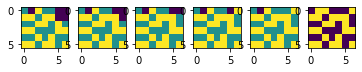

In [11]:
one_wins = False
two_wins = False
draw = True


initial_board = np.zeros((6, 7), int)
state = State(board = initial_board, player = 2)

state.board = np.array([
    [1, 0, 2 ,1 ,1, 0, 0],
    [2, 2, 1, 2, 2, 0, 0],
    [1, 1, 2, 2, 1, 2, 1],
    [2, 2, 1, 1, 1, 2, 2],
    [1, 1, 2, 1, 2, 1, 1],
    [2, 2, 1, 2, 2, 1, 2],
    ])


if one_wins:
    fig, ax = plt.subplots(ncols=5)
    ax[0].imshow(state.board)

    print(f"start\n\tplayer: {state.player}\n\tactions: {state.get_actions()}\n\tgame over/ winner: {state.game_over}/ {state.winner}\n")

    state = state.perform_action(6)
    ax[1].imshow(state.board)
    print(f"after column 6\n\tplayer: {state.player}\n\tactions: {state.get_actions()}\n\tgame over/ winner: {state.game_over}/ {state.winner}\n")

    state = state.perform_action(5)
    ax[2].imshow(state.board)
    print(f"after column 5\n\tplayer: {state.player}\n\tactions: {state.get_actions()}\n\tgame over/ winner: {state.game_over}/ {state.winner}\n")
    
    state = state.perform_action(5)
    ax[3].imshow(state.board)
    print(f"after column 5\n\tplayer: {state.player}\n\tactions: {state.get_actions()}\n\tgame over/ winner: {state.game_over}/ {state.winner}\n")

    state = state.perform_action(6)
    ax[4].imshow(state.board)
    print(f"after column 6\n\tplayer: {state.player}\n\tactions: {state.get_actions()}\n\tgame over/ winner: {state.game_over}/ {state.winner}\n")
    
    plt.show()
    
elif two_wins:
    fig, ax = plt.subplots(ncols=4)
    ax[0].imshow(state.board)

    print(f"start\n\tplayer: {state.player}\n\tactions: {state.get_actions()}\n\tgame over/ winner: {state.game_over}/ {state.winner}\n")

    state = state.perform_action(6)
    ax[1].imshow(state.board)
    print(f"after column 6\n\tplayer: {state.player}\n\tactions: {state.get_actions()}\n\tgame over/ winner: {state.game_over}/ {state.winner}\n")

    state = state.perform_action(6)
    ax[2].imshow(state.board)
    print(f"after column 6\n\tplayer: {state.player}\n\tactions: {state.get_actions()}\n\tgame over/ winner: {state.game_over}/ {state.winner}\n")
    
    state = state.perform_action(5)
    ax[3].imshow(state.board)
    print(f"after column 5\n\tplayer: {state.player}\n\tactions: {state.get_actions()}\n\tgame over/ winner: {state.game_over}/ {state.winner}\n")
    
    plt.show()
    
elif draw:
    fig, ax = plt.subplots(ncols=6)
    ax[0].imshow(state.board)

    print(f"start\n\tplayer: {state.player}\n\tactions: {state.get_actions()}\n\tgame over/ winner: {state.game_over}/ {state.winner}\n")

    state = state.perform_action(5)
    ax[1].imshow(state.board)
    print(f"after column 5\n\tplayer: {state.player}\n\tactions: {state.get_actions()}\n\tgame over/ winner: {state.game_over}/ {state.winner}\n")

    state = state.perform_action(6)
    ax[2].imshow(state.board)
    print(f"after column 6\n\tplayer: {state.player}\n\tactions: {state.get_actions()}\n\tgame over/ winner: {state.game_over}/ {state.winner}\n")
    
    state = state.perform_action(6)
    ax[3].imshow(state.board)
    print(f"after column 6\n\tplayer: {state.player}\n\tactions: {state.get_actions()}\n\tgame over/ winner: {state.game_over}/ {state.winner}\n")
    
    state = state.perform_action(5)
    ax[4].imshow(state.board)
    print(f"after column 5\n\tplayer: {state.player}\n\tactions: {state.get_actions()}\n\tgame over/ winner: {state.game_over}/ {state.winner}\n")
    
    state = state.perform_action(1)
    ax[5].imshow(state.board)
    print(f"after column 1\n\tplayer: {state.player}\n\tactions: {state.get_actions()}\n\tgame over/ winner: {state.game_over}/ {state.winner}\n")
    
    plt.show()

### check win

In [12]:
initial_board = np.zeros((6, 7), int)
state = State(board = initial_board, player = 2)

# diagonal upwards
state.board = np.array([
    [1, 0, 2 ,1 ,2, 0, 0],
    [2, 2, 1, 2, 2, 0, 0],
    [1, 1, 2, 2, 1, 2, 1],
    [2, 2, 1, 1, 1, 2, 2],
    [1, 1, 2, 1, 2, 1, 1],
    [2, 2, 1, 2, 2, 1, 2],
    ])

winner = state.check_win(state.board, 0, 4)
print(f"diagonal upwards: {winner} <-- should be 2\ntested at (0, 4)\n")

# diagonal downwards
state.player = state.change_player()
state.board = np.array([
    [1, 0, 2 ,1 ,1, 0, 0],
    [2, 2, 1, 2, 2, 0, 0],
    [1, 1, 2, 2, 1, 2, 1],
    [2, 2, 1, 1, 1, 2, 2],
    [1, 1, 2, 1, 2, 1, 1],
    [2, 2, 1, 2, 1, 1, 2],
    ])

winner = state.check_win(state.board, 4, 3)
print(f"diagonal downwards: {winner} <-- should be 1\ntested at (4, 3)\n")

# horizontal
state.player = state.change_player()
state.board = np.array([
    [1, 0, 2 ,1 ,1, 0, 0],
    [2, 2, 1, 2, 2, 0, 0],
    [1, 1, 2, 2, 1, 2, 1],
    [2, 2, 1, 1, 1, 2, 2],
    [1, 1, 2, 1, 2, 1, 1],
    [2, 2, 1, 2, 2, 2, 2],
    ])

winner = state.check_win(state.board, 5, 6)
print(f"horizontal: {winner} <-- should be 2\ntested at (5, 6)\n")

# vertical
state.player = state.change_player()
state.board = np.array([
    [1, 0, 2 ,1 ,1, 0, 0],
    [2, 2, 1, 2, 1, 0, 0],
    [1, 1, 2, 2, 1, 2, 1],
    [2, 2, 1, 1, 1, 2, 2],
    [1, 1, 2, 1, 2, 1, 1],
    [2, 2, 1, 2, 2, 2, 2],
    ])

winner = state.check_win(state.board, 1, 4)
print(f"horizontal: {winner} <-- should be 1\ntested at (1, 4)\n")

diagonal upwards: 2 <-- should be 2
tested at (0, 4)

diagonal downwards: 1 <-- should be 1
tested at (4, 3)

horizontal: 2 <-- should be 2
tested at (5, 6)

horizontal: 1 <-- should be 1
tested at (1, 4)



### simulation

1


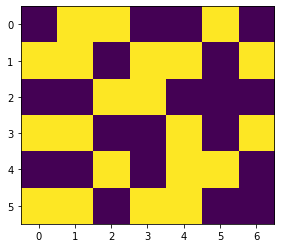

In [13]:
initial_board = np.zeros((6, 7), int)
state = State(board = initial_board, player = 2)

state.board = np.array([
    [1, 0, 2 ,1 ,0, 0, 0],
    [2, 2, 1, 2, 0, 0, 0],
    [1, 1, 2, 2, 1, 0, 1],
    [2, 2, 1, 1, 2, 1, 2],
    [1, 1, 2, 1, 2, 2, 1],
    [2, 2, 1, 2, 2, 1, 1],
    ])

root = Node(None, state)

winner, sim_state = simulate(root)

plt.imshow(sim_state)
print(winner)

#### Selection - First Turn

In [14]:
# setup small board

initial_board = np.zeros((4, 4), int)
state = State(board = initial_board, player = 1)

# check random picks --> should be close to equally distributed
picked_nodes = np.zeros_like(state.board)
for i in range(500):
    node = Node(None, state)
    new_node = select_node(node)
    picked_nodes = picked_nodes + new_node.state.board

picked_nodes = picked_nodes[3, :] / 500
print(f"random picks: {picked_nodes}")
print(f"root children: {len(node.children)}")

random picks: [0.25  0.236 0.27  0.244]
root children: 1


#### Selection - tree expansion

In [15]:
# setup small board

initial_board = np.zeros((4, 4), int)
state = State(board = initial_board, player = 1)

node = Node(None, state)

# get first 4 calculations
for i in range(4):
    new_node = select_node(node)
    winner, _ = simulate(node)
    backpropagate(new_node, winner)
    
# check if every position is taken
positions = np.array([0, 0, 0, 0])
times_tested = 0
for child in node.children:
    positions += child.state.board[3,:]
    times_tested += child.times_tested 

print("Before Expansion")
print(f"Sum of positions of root's cildren: {positions} <-- should be [1, 1, 1, 1]")
print(f"times_tested: Root = {node.times_tested}, Sum of children = {times_tested} with {len(node.children)} children")
print("\n")
print("Stats for decision making")
times_won = [child.times_won for child in node.children]
print(f"wins per child node: {times_won}")

new_node = select_node(node)
print(new_node.edges)
new_node.state.board

Before Expansion
Sum of positions of root's cildren: [1 1 1 1] <-- should be [1, 1, 1, 1]
times_tested: Root = 4, Sum of children = 4 with 4 children


Stats for decision making
wins per child node: [1, 0, 0, 0]
[2.66510922 1.66510922 1.66510922 1.66510922]
[0, 1, 2, 3]


array([[0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [1, 0, 2, 0]])

In [16]:
from treelib import Node, Tree

# setup small board

initial_board = np.zeros((4, 4), int)
state = State(board = initial_board, player = 1)

node = Node(None, state)

# get first 4 calculations
for i in range(100):
    new_node = select_node(node)
    winner, _ = simulate(node)
    backpropagate(new_node, winner)

tree = Tree()
tree.create_node(f"wins: {node.times_won}\ntests: {node.times_tested}\nboard: {node.state.board}")

f


AttributeError: 'Node' object has no attribute 'edges'

In [17]:
initial_board = np.zeros((6, 7), int)
state = State(board = initial_board, player = 2)

# state.board = np.array([
#     [1, 0, 2 ,0 ,0, 0, 0],
#     [2, 2, 1, 0, 0, 0, 0],
#     [1, 1, 2, 0, 1, 0, 1],
#     [2, 2, 1, 0, 2, 1, 2],
#     [1, 1, 2, 1, 2, 2, 1],
#     [2, 2, 1, 2, 2, 1, 1],
#     ])

root = Node(None, state)

plt.style.use('seaborn-darkgrid')

print(f"root -> edges {root.edges}, children {len(root.children)}, tests {root.times_tested}, wins {root.times_won}")
   
for i in range(500):
    node = select_node(root)
    winner, sim_state = simulate(node)
    backpropagate(node, winner)

print(f"root -> edges {root.edges}, children {len(root.children)}, tests {root.times_tested}, wins {root.times_won}")  
print([child.times_won / child.times_tested for child in root.children])

action_values = [child.times_won / child.times_tested for child in root.children]
turn_2_state = root.children[np.argmax(action_values)].state

plt.imshow(turn_2_state.board)
plt.show()

for child in root.children:
    plt.imshow(child.state.board)
    plt.show()
    if np.array_equal(turn_2_state.board, child.state.board):
        print("Action found")

AttributeError: 'Node' object has no attribute 'edges'

In [ ]:
a = np.array([
    [1, 0, 2 ,0 ,0, 0, 0],
    [2, 2, 1, 0, 0, 0, 0],
    [1, 1, 2, 0, 1, 0, 1],
    [2, 2, 1, 0, 2, 1, 2],
    [1, 1, 2, 1, 2, 2, 1],
    [2, 2, 1, 2, 2, 1, 1],
    ])

b = np.array([
    [1, 0, 2 ,0 ,0, 0, 0],
    [2, 2, 1, 0, 0, 0, 0],
    [1, 1, 2, 0, 1, 0, 1],
    [2, 2, 1, 0, 2, 1, 2],
    [1, 1, 2, 1, 2, 2, 1],
    [2, 2, 1, 2, 2, 1, 1],
    ])

if np.array_equal(a, b):
    print("!")

!
